# Final Model

Our final model, although the one in cli.py has some improvements and better code, this one is just a demonstration.

In [1]:
import sys

sys.path.append("..")

import time
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from utils import config

We import the data base with the sql3 with the indicator names in the config file found in the chosing_indicators report.

In [2]:
%%time
# Load data from the dataset
separator = "','"
sql_read_query = f""" SELECT
                t2.CountryCode as Country,
                t1.Year,
                t3.IndicatorName,
                t1.Value                
                FROM CountryIndicators t1
                LEFT JOIN
                (SELECT ShortName as Country, CountryCode from Countries) t2
                ON t1.CountryCode = t2.CountryCode
                LEFT JOIN
                (SELECT IndicatorCode, IndicatorName from Indicators)t3
                ON t1.IndicatorCode = t3.IndicatorCode
                WHERE t3.IndicatorName in ('{separator.join(config.INDICATORS)}');"""

with sqlite3.connect(config.DATABASE_PATH) as conn:
    country_indicators_df = pd.read_sql(sql_read_query,conn)

CPU times: user 4.56 s, sys: 94 ms, total: 4.65 s
Wall time: 4.66 s


We create a colum for each indicator ussing the pivot function and print the number of indicators. We load the target and the gdp field names from the config file.

In [3]:
target = config.TARGET
gdp = config.GDP_GROWTH
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])

features = pivoted_df.columns.tolist()
print("Features Len:",len(features))

Features Len: 50


Commented code for previous year -> flag in cli.py, although we didn't see much of a difference.

We create a new column with the target ("Next GDP Growth").

We only use dropna for the rows where our target is missing, otherwise XGBoost can deal with them.

In [4]:
# for indicator in features:
#    indicator_1 = country_indicators_df.loc[country_indicators_df["IndicatorName"] == indicator].copy()
#    indicator_1["Year"] += 1
#    indicator_1.set_index(["Country", "Year"], inplace=True)
#    indicator_1.rename(columns={"Value": "Previous "+indicator}, inplace=True)
#    indicator_1.drop(columns=["IndicatorName"], inplace=True)
#    pivoted_df = pivoted_df.join(indicator_1)
# features = pivoted_df.columns.tolist()

target_df = country_indicators_df.loc[country_indicators_df["IndicatorName"] == gdp].copy()
target_df["Year"] -= 1
target_df.set_index(["Country", "Year"], inplace=True)
target_df.rename(columns={"Value": "Next GDP Growth"}, inplace=True)
target_df.drop(columns=["IndicatorName"], inplace=True)
df = pivoted_df.join(target_df)

df = df.dropna(subset=[target])  # Drop row if target is not present
df.shape

(9057, 51)

Test-train split

In [5]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6339, 50)
X_test shape: (2718, 50)
y_train shape: (6339,)
y_test shape: (2718,)


Initialize model, with parameters in config file.

In [6]:
xg_reg = xgb.XGBRegressor(**config.XG_PARAMS)

Train and test model and print its performance.

In [7]:
t0 = time.time()
xg_reg.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
xg_reg_y_pred = xg_reg.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

results_df = X_test
results_df = results_df.drop(columns=features)
results_df["y_real"] = y_test
results_df["y_pred"] = xg_reg_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, xg_reg_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, xg_reg_y_pred)}")

results_df 

Elapsed time training: 0.8164055347442627 seconds
Elapsed time predicting: 0.011344671249389648 seconds
RMSE: 5.211305797383047
R^2: 0.2113373985391559


,,y_real,y_pred,err,%_err
Country,Year,,,,
ALB,1982,1.104938,3.291899,2.186961,197.926075
GHA,1983,8.647569,1.296926,7.350644,85.002426
HTI,2007,0.843944,3.654202,2.810258,332.990881
COG,1977,6.359747,1.776129,4.583618,72.072327
MNA,1996,3.052934,4.723700,1.670766,54.726580
...,...,...,...,...,...
CRI,2008,-1.015719,2.949871,3.965590,390.422003
MIC,1986,4.469074,3.640579,0.828496,18.538422
MEX,2004,3.032574,3.928191,0.895617,29.533241


If executed from cli.py, plots are created from the module plots.py and exported to the models folder.


Plot of the model performance.

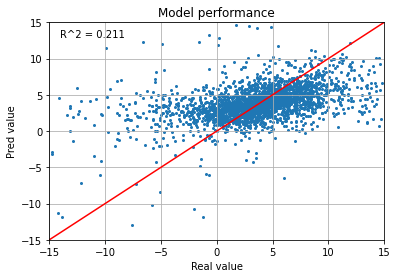

In [8]:
fig, ax = plt.subplots()
plot_range = [y_test.min(), y_test.max()]
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")
ax.scatter(y_test, xg_reg_y_pred, s=4)
ax.plot(plot_range, plot_range, c="red")
plt.xlim((-15, 15))
plt.ylim((-15, 15))
plt.grid()
plt.annotate("R^2 = {:.3f}".format(r2_score(y_test, xg_reg_y_pred)), (-14, 13))
plt.show()

Here, the year column is hardcoded, while in cli.py it is the last one present in the database, or the one given as an input.

We predict the GDP Growth for 2011 using the indicators from the previous year, and print the dataframe with all the country indicators and the predicted values.

In [9]:
# Prediction for 2011, using the last indicators info
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])
country_list = pivoted_df.index.unique('Country')

#Dataframe with all the countries
predictions = pd.DataFrame(country_list) 
predictions["Year"] = 2011
predictions["Value"] = xg_reg.predict(pivoted_df.filter(like = f"{2010}", axis=0))
predictions.rename(columns={'Country': 'CountryCode'}, inplace=True)
predictions

,CountryCode,Year,Value
0,ABW,2011,1.533444
1,ADO,2011,0.262308
2,AFG,2011,6.592370
3,AGO,2011,3.181497
4,ALB,2011,3.312258
...,...,...,...
242,YEM,2011,4.117894
243,ZAF,2011,2.814033
244,ZAR,2011,6.444986
245,ZMB,2011,8.510641


Safe data frame into sql3 data base.

In [10]:
with sqlite3.connect(config.DATABASE_PATH) as conn:
    predictions.to_sql('EstimatedGDPGrowth', conn, if_exists='replace', index = False)

In [11]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)

In [12]:
%%time
shap_values = explainer.shap_values(X_test)

CPU times: user 3.11 s, sys: 12.3 ms, total: 3.12 s
Wall time: 472 ms


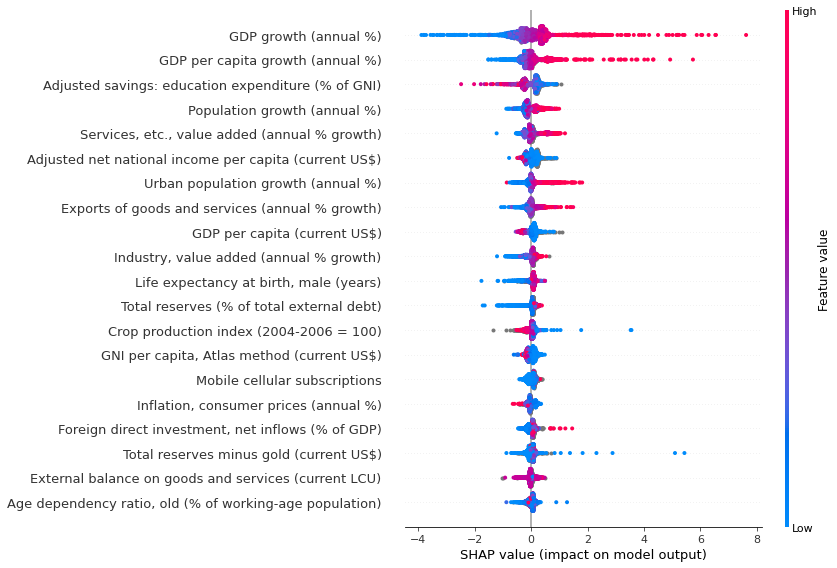

In [13]:
shap.summary_plot(shap_values, X_test,feature_names=features)

We can see that the GDP growth and the GDP growth per capita are the most important indicators to predict the next year GDP growth, no surprise here.

The third one is interresting though, the expense in education seems to be a good predictor of GDP growth.

Note, that indicators realted to population make a big impact on the model.

Finally, macro economics realated indicators are also imporant on the prediction.

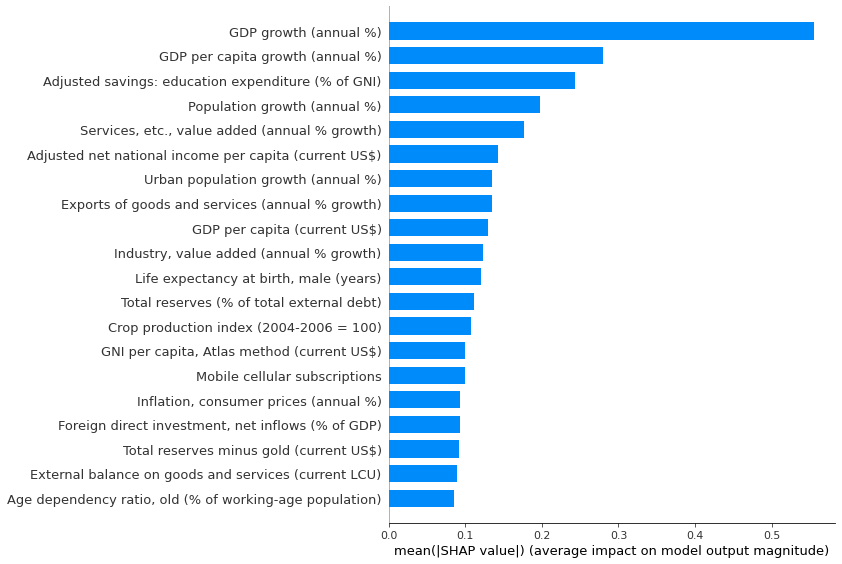

In [14]:
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=features)

To conclude, our model is not really effective, but can predict the tendency of different countries.